# 飞桨常规赛：PALM眼底彩照中黄斑中央凹定位 - 5月第一名方案
这个第一真的奇葩，看着自己0.009分的成绩，100多的平均欧氏距离。我很怀疑大佬们不愿意来玩。老规矩，虽然很菜，也分享一下我的想法，看对大家有没有一点帮助。

## 0. 赛题介绍
常规赛：PALM病理性近视预测由ISBI2019 PALM眼科挑战赛赛题再现，其中黄斑中央凹定位的任务旨在对眼科图像进行判断是否存在黄斑中央凹，并对其进行定位。

数据集由中山大学中山眼科中心提供800张带黄斑中央凹坐标标注的眼底彩照供选手训练模型，另提供400张带标注数据供平台进行模型测试。图像分辨率为1444×1444，或2124×2056。黄斑中央凹坐标信息存储在xlsx文件中，名为“Fovea_Location_train”，第一列对应眼底图像的文件名(包括扩展名“.jpg”)，第二列包含x坐标，第三列包含y坐标。

评价指标为平均欧式距离，计算每个测试样本预测的黄斑中央凹坐标与金标准的差距，最终计算平均的欧式距离。 最终评分为平均欧式距离的倒数。

![](https://ai-studio-static-online.cdn.bcebos.com/d229312f2d244037b5ec3cce55da977ec4589408156b4947b49802373371bf2b)

比赛链接: [常规赛：PALM眼底彩照中黄斑中央凹定位](https://aistudio.baidu.com/aistudio/competition/detail/86)

## 1. 包准备
本来的想法是既然眼疾分类的效果比较好，就用眼疾分类的模型再加上FC进行回归，所以就把ppim搞下来了，可是后来大概在欧式距离160左右就下不来了，也不知道哪儿除了问题，所以后面又该用了resnet50加载一个训练更多的预训练模型。

In [ ]:
# ! pip -q install ppim

You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


## 2. 数据准备
### 2.1解压数据集
这个没啥好写的。

In [ ]:
# ! unzip -oq /home/aistudio/data/data85130/常规赛：PALM眼底彩照中黄斑中央凹定位.zip
# ! rm -rf __MACOSX
# ! mv 常规赛：PALM眼底彩照中黄斑中央凹定位 PLAM

## 2.2 配置数据集
1. 因为数据中本身就有了这个图像名和标签，我们就不用生成数据列表了。直接继承io中的Dataset，用于读取数据。因为与开始说数据的大小有两种分辨率，而且贼大，但是又不敢放的太小损失太多细节，所以这里都放到了1120X1120。
2. 划分的比列为0.9，图像增强只有简单的色彩和水平翻转。
3. 这里主要注意当图像大小发生了变化，对应的中央凹的坐标也需要进行相应的变化。数据增广就没有写几何变换有关的了，因为这样就要自己写一下对应增强。
4. 最开始数据我还加上了是否存在的类别标签，但是后期效果不明显，可能是自己的原因，这里给注释了，大佬们觉得有道理也可是试试。

In [ ]:
import os
import pandas as pd
import numpy as np
import paddle
import paddle.vision.transforms as T
from paddle.io import Dataset
from PIL import Image

class PLAMDatas(Dataset):
    def __init__(self, data_path, class_xls, mode='train', transforms=None, re_size=1120):
        super(PLAMDatas, self).__init__()
        self.data_path = data_path
        self.name_label = (pd.read_excel(class_xls)).values
        lens = len(self.name_label)
        if mode == 'train':
            self.name_label = self.name_label[:int(0.9*lens)]
        else:
            self.name_label = self.name_label[int(0.9*lens):]
        self.transforms = transforms
        self.re_size = re_size
        
    def __getitem__(self, index):
        name, x, y = self.name_label[index]
        data_path = os.path.join(self.data_path, name)
        data = np.asarray(Image.open(data_path).convert('RGB'))
        H, W, _ = data.shape
        if self.transforms is not None:
            data = self.transforms(data)
        data = data.astype('float32')
        # 这里之前还加上了分类的标签，表明有这个东西的坐标还是没坐标
        # if x != 0 and y != 0:
        #     label = np.array([1, x * self.re_size / W, y * self.re_size / H])
        # else:
        #     label = np.array([0, x * self.re_size / W, y * self.re_size / H])
        label = np.array([x * self.re_size / W, y * self.re_size / H]).astype('float32')
        return data, label
        
    def __len__(self):
        return len(self.name_label)

# 配置数据增广
train_transforms = T.Compose([
    T.Resize((1120, 1120), interpolation='bicubic'),
    T.ColorJitter(0.1, 0.1, 0.1, 0.1),
   	T.ToTensor()
])

val_transforms = T.Compose([
    T.Resize((1120, 1120), interpolation='bicubic'),
    T.ToTensor()
])

# 配置数据集
train_dataset = PLAMDatas(data_path='PLAM/Train/fundus_image', class_xls='PLAM/Train/Fovea_Location_train.xlsx', mode='train', transforms=train_transforms)
val_dataset = PLAMDatas(data_path='PLAM/Train/fundus_image', class_xls='PLAM/Train/Fovea_Location_train.xlsx', mode='test', transforms=val_transforms)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):


这里也可以输出测试一下，看看数据读取有没有什么问题。避免后面报一堆错不知道哪儿去找问题。顺便看看点是不是点到位了。

In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# print(len(train_dataset), len(val_dataset))
# for img, lab in train_dataset:
#     print(img.shape, lab)
#     x, y = lab[1], lab[2]
#     plt.imshow(img.astype('uint8'))
#     plt.plot(x, y, 'om')
#     plt.show()
#     break
# for img ,lab in val_dataset:
#     print(img.shape, lab)
#     break

## 3. 模型训练
### 3.1 模型准备
1. 这里最开始直接采用的是眼疾分类那个模型和参数，后来试了一试发现resnet50也不错，也不知道咋搞的，是不是改的太多清不到哪个影响比较大了。我感觉定位应该不是简单的这样回归，这是我从人脸特征点检测看来的方法。官方提供了有相关论文，奈何英语差看得慢事情多，就没看。我觉得要搞好这个定位，还是得去看看那两篇论文。
2. 最开始的我的FC返回的是4个值，前两个表示有没有黄斑中央凹，后面两个表示xy坐标。后来给去掉了前面的判断，改为直接回归坐标了。

In [1]:
import paddle
import paddle.nn as nn
# from ppim import DistilledVisionTransformer
from paddle.vision.models import resnet50

# 模型定义
# model = DistilledVisionTransformer(img_size=1120, patch_size=64, class_dim=4)
# pre_params = paddle.load('save_models/last.pdparams')
# model.set_state_dict(pre_params)
model = nn.Sequential(
    resnet50(pretrained=True),
    nn.LeakyReLU(),
    nn.Linear(1000, 2)  # 坐标定位
)
paddle.summary(model, (1, 3, 1120, 1120))
model = paddle.Model(model)

2021-05-09 09:20:10,155 - INFO - unique_endpoints {''}
2021-05-09 09:20:10,157 - INFO - Downloading resnet50.pdparams from https://paddle-hapi.bj.bcebos.com/models/resnet50.pdparams
100%|██████████| 151272/151272 [00:04<00:00, 35010.23it/s]
2021-05-09 09:20:14,632 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet50.pdparams md5 checking...


-------------------------------------------------------------------------------
   Layer (type)         Input Shape          Output Shape         Param #    
     Conv2D-1       [[1, 3, 1120, 1120]]  [1, 64, 560, 560]        9,408     
   BatchNorm2D-1    [[1, 64, 560, 560]]   [1, 64, 560, 560]         256      
      ReLU-1        [[1, 64, 560, 560]]   [1, 64, 560, 560]          0       
    MaxPool2D-1     [[1, 64, 560, 560]]   [1, 64, 280, 280]          0       
     Conv2D-3       [[1, 64, 280, 280]]   [1, 64, 280, 280]        4,096     
   BatchNorm2D-3    [[1, 64, 280, 280]]   [1, 64, 280, 280]         256      
      ReLU-2        [[1, 256, 280, 280]]  [1, 256, 280, 280]         0       
     Conv2D-4       [[1, 64, 280, 280]]   [1, 64, 280, 280]       36,864     
   BatchNorm2D-4    [[1, 64, 280, 280]]   [1, 64, 280, 280]         256      
     Conv2D-5       [[1, 64, 280, 280]]   [1, 256, 280, 280]      16,384     
   BatchNorm2D-5    [[1, 256, 280, 280]]  [1, 256, 280, 280]  

## 3.2 损失设定
这里自己设计了一下loss，发现奇奇怪怪的。
1. LocationLoss当时主要是针对前面的类别和坐标两种输出，希望既保证分类正确又保证定位准确。结果好像因为尺度不一样，导致后面loss有点降不下去。
2. 后面的LMLoss是改成坐标回归后的损失，因为L1和MSE在训练的前后期各有优劣，所以为了避免选择，就把L1和MSE合起来作为了损失。

In [2]:
# 自定义损失
import paddle
import paddle.nn as nn
import paddle.nn.functional as F

# class LocationLoss(nn.Layer):
#     def __init__(self):
#        super(LocationLoss, self).__init__()

#     def forward(self, input, label):
#         lab, loc_lab = label[:, 0].astype('int64'), label[:, 1:].astype('float32')
#         pre, loc_pre = input[:, :2].astype('float32'), input[:, 2:].astype('float32')
#         mask_loss = F.cross_entropy(pre, lab)
#         loc_l1_loss = F.l1_loss(loc_pre, loc_lab)
#         loc_l2_loss = F.mse_loss(loc_pre, loc_lab)
#         loc_ml1_loss = F.smooth_l1_loss(loc_pre, loc_lab)
#         mask = paddle.equal(paddle.argmax(pre, axis=1), lab).astype('float32')
#         return (loc_l1_loss + loc_ml1_loss) / 2  + sum((1 - mask) * mask_loss)

class LMLoss(nn.Layer):
    def __init__(self, iters, chang_num=10, decy_rate=0.1):
        super(LMLoss, self).__init__()
        self.decy_iter = iters // chang_num
        self.decy_rate = decy_rate
        self.idx = 0
        self.a = 0
        self.b = 1

    def forward(self, input, label):
        loc_l1_loss = (F.l1_loss(input, label) + F.smooth_l1_loss(input, label)) / 2.
        loc_l2_loss = F.mse_loss(input, label)
        self.idx += 1
        if self.idx == self.decy_iter:
            self.a += self.decy_rate
            self.b -= self.decy_rate
        return (self.a * loc_l1_loss + self.b * loc_l2_loss)


# input = paddle.to_tensor([[190.67, 109.34], [156.99, 333.45], [75.41, 64.66]])
# label = paddle.to_tensor([[120.5, 114.4], [160.4, 332.9], [0.0, 0.0]])
# output = LMLoss(100)(input, label)
# print(output)

Tensor(shape=[1], dtype=float32, place=CPUPlace, stop_gradient=True,
       [2471.49121094])


## 3.3 开始训练
这里分别用CosineAnnealingDecay和PolynomialDecay跑过，得到的结果并不算好，具体问题我感觉是方法的问题。

In [ ]:
# 模型准备
epochs = 100
batch_size = 16
iters = epochs * len(train_dataset) // batch_size
lr = paddle.optimizer.lr.CosineAnnealingDecay(base_lr, T_max=(iters // 10))
# lr = paddle.optimizer.lr.PolynomialDecay(learning_rate=3e-4, decay_steps=int(800*0.9))
opt = paddle.optimizer.Adam(learning_rate=lr, parameters=model.parameters(), weight_decay=paddle.regularizer.L2Decay(1e-7))
loss = LMLoss(iters)
model.prepare(optimizer=opt, loss=loss)
visualdl=paddle.callbacks.VisualDL(log_dir='visual_log')

# 模型微调
model.fit(
    train_data=train_dataset, 
    eval_data=val_dataset, 
    batch_size=batch_size, 
    epochs=epochs, 
    eval_freq=20, 
    log_freq=1, 
    save_dir='resnet_50_save_models', 
    save_freq=20, 
    verbose=1, 
    drop_last=False, 
    shuffle=True,
    num_workers=0,
    callbacks=[visualdl]
)

The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/200


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(slot[0], (np.ndarray, np.bool, numbers.Number)):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and


step 23/23 [==============================] - loss: 80.6084 - 12s/step          
save checkpoint at /home/aistudio/save_models/0
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 3/3 [==============================] - loss: 33.6745 - 8s/step          
Eval samples: 80
Epoch 2/200
step 23/23 [==============================] - loss: 32.6033 - 9s/step         
Epoch 3/200
step 23/23 [==============================] - loss: 43.2475 - 11s/step         
Epoch 4/200
step 23/23 [==============================] - loss: 41.4214 - 9s/step        
Epoch 5/200
step 23/23 [==============================] - loss: 31.1571 - 10s/step         
Epoch 6/200
step 23/23 [==============================] - loss: 37.0004 - 9s/step         
Epoch 7/200
step 23/23 [==============================] - loss: 39.3255 - 9s/step        
Epoch 8/200
step 23/23 [==============================] - loss: 48.5570 - 8s/step         
Epoch 9/200
ste

降不下来的可怜虫
```
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 3/3 [==============================] - loss: 32.7970 - 3s/step        
Eval samples: 80
```

## 4. 模型预测
预测这里就是因为图像的大小变了，所以预测得到的坐标还需要进行一次计算还原到原来的大小，感觉这也是误差的一个来源。

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import paddle.vision.transforms as T
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
# from ppim import DistilledVisionTransformer
from paddle.vision.models import resnet50

save_path = 'Fovea_Localization_Results.csv'
file_path = 'PLAM/PALM-Testing400-Images'
imgs_name = os.listdir(file_path)

# model = DistilledVisionTransformer(
#     img_size=1120,
#     patch_size=64,
#     class_dim=4)
model = nn.Sequential(
    resnet50(pretrained=False),
    nn.LeakyReLU(),
    nn.Linear(1000, 2)
)
params = paddle.load('resnet50_save_models/finish.pdparams')
model.set_state_dict(params)
model.eval()

inf_transforms = T.Compose([
    T.Resize((1120, 1120), interpolation='bicubic'),
    T.ToTensor()
])

pre_data = []
for img_name in imgs_name:
    data_path = os.path.join(file_path, img_name)
    data = np.asarray(Image.open(data_path).convert('RGB'))
    H, W, _ = data.shape
    data = inf_transforms(data)
    data = data.astype('float32').reshape([1, 3, 1120, 1120])
    pred = model(data)
    # 这是当时的分类和定位任务一起，若分类不存在黄斑中央凹，则不定位
    # clas = paddle.argmax(pred[:, :2], axis=1)
    # pre = pred.numpy()[0][2:]
    # if clas.numpy()[0] == 1: 
    #     pre[0] = pre[0] * W / 1120
    #     pre[1] = pre[1] * H / 1120
    # else:
    #     pre[0] = 0.0
    #     pre[1] = 0.0
    pre = [None] * 2
    # 还原坐标
    pre[0] = pred.numpy()[0][0] * W / 1120
    pre[1] = pred.numpy()[0][1] * H / 1120
    print(img_name, pre)
    pre_data.append([img_name, pre[0], pre[1]])

df = pd.DataFrame(pre_data, columns=['FileName', 'Fovea_X', 'Fovea_Y'])
df.to_csv(save_path, index=None)

## 5. 查看结果
我也看不出来啥结果。。。。估计我自己都找不到黄斑中央凹在哪儿。。。

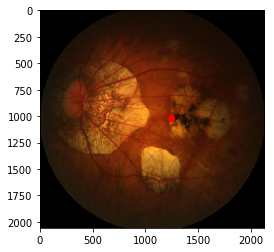

In [11]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

path = 'PLAM/PALM-Testing400-Images'
flrs = np.array(pd.read_csv('Fovea_Localization_Results.csv'))
for flr in flrs:
    img = np.array(Image.open(os.path.join(path, flr[0])))
    x, y = flr[1:]
    plt.imshow(img.astype('uint8'))
    plt.plot(x, y, 'or')
    plt.show()
    break

## 心得
1. 对于分类和回归一起做，我感觉是可以的，但是怎么较比好的放在一起涨分还不清楚。
2. 感觉这个和人脸关键点检测不一样，直接回归坐标效果不太好！
3. 还是抽空把论文看了吧。。
## *即将参考资料
眼底彩照中黄斑中央凹定位相关论文
1. [Macula segmentation and fovea localization employing image processing and heuristic based clustering for automated retinal screening](https://www.sciencedirect.com/science/article/abs/pii/S0169260717304145)
2. [A Pixel-Wise Distance Regression Approach for Joint Retinal Optic Disc and Fovea Detection](https://agaldran.github.io/pdf/od_fovea_location.pdf)